### GPU Open Analytics Initiative: connect MapD to PyGDF to H2OAIGLM

### In this demo, we will train 4000 regularized linear regression models on the U.S. Census dataset, with the goal to predict the income of a person, given approximately 10000 data points (such as age, occupation, zip code, etc.)

### The dataset is about 2GB in memory (50k rows, 10k cols, single-precision floating-point values), so it fits onto the GPU memory.

### By using multiple GPUs, we are able to speed up this process significantly, and can train about 40 models per second (on a DGX-1 with 8 GPUs)

### Choose to Run or Run+Animate

### Define some helper methods for plotting and running the algorithm

In [1]:
import pandas as pd
import time
def new_alpha(row_fold):
    if row_fold == 0:
        return -0.025
    elif row_fold == 1:
        return -0.05
    elif row_fold == 3:
        return 0.025
    elif row_fold == 4:
        return 0.05
    else: return 0

def plot_cpu_perf(axis, cpu_labels, cpu_snapshot):
    axis.cla()
    axis.grid(False)
    axis.set_ylim([0,100])
    axis.set_ylabel('Percent', labelpad=2, fontsize = 14)
    axis.bar(cpu_labels, cpu_snapshot, color='dodgerblue')
    axis.set_title('CPU Utilization', fontsize = 16)
    
def plot_gpu_perf(axis, gpu_labels, gpu_snapshot):
    axis.cla()
    axis.grid(False)
    axis.set_ylim([0,100])
    axis.set_xticks(gpu_labels)
    axis.set_ylabel('Percent', labelpad=2, fontsize = 14)
    axis.bar(gpu_labels, gpu_snapshot, width =0.5, color = 'limegreen')
    axis.set_title('GPU Utilization', fontsize = 16)
    
def plot_glm_results(axis, results, best_rmse, cb):
    axis.cla()
    axis.set_xscale('log')
    axis.set_xlim([0.1, 1e9])
    axis.set_ylim([-0.12, 1.12])
    axis.set_yticks([x/7. for x in range(0,8)])
    axis.set_ylabel('Parameter 1:  '+r'$\alpha$', fontsize = 16)
    axis.set_xlabel('Parameter 2:  '+r'$\lambda$', fontsize = 16)
    num_models = min(4000,int(4000*results.shape[0]/2570))
    axis.set_title('Elastic Net Models Trained and Evaluated: ' + str(num_models), fontsize = 16)

    try:
        cm = ListedColormap(sns.color_palette("RdYlGn", 10).as_hex())
        cf = axis.scatter(results['lambda'], results['alpha_prime'], c=results['rel_acc'], 
                    cmap=cm, vmin=0, vmax=1)
        axis.plot(best_rmse['lambda'],best_rmse['alpha_prime'], 'o',
            ms=15, mec='k', mfc='none', mew=2)

        if cb is None:
            cb = pl.colorbar(cf, ax=axis)
            cb.set_label('Relative  Validation  Accuracy', rotation=270, 
                         labelpad=18, fontsize = 16)   
        cb.update_normal(cf)
    except Exception as e:
        print("plot_glm_results exception -- no frame: %s" % str(e))
        pass
    return cb

from py3nvml.py3nvml import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style("whitegrid")
import psutil
import numpy as np
import pylab as pl
from IPython import display
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import sys
import subprocess
maxNGPUS = int(subprocess.check_output("nvidia-smi -L | wc -l", shell=True))
print("Maximum Number of GPUS:", maxNGPUS)

nvmlInit()
deviceCount = nvmlDeviceGetCount()
for i in range(deviceCount):
    handle = nvmlDeviceGetHandleByIndex(i)
    #print("Device {}: {}".format(i, nvmlDeviceGetName(handle)))
    #print ("Driver Version:", nvmlSystemGetDriverVersion())

import os
import os.path
file_error = os.getcwd() + "/error.txt"
file_stop = os.getcwd() + "/stop.txt"
if os.path.isfile(file_stop):
    os.remove(file_stop)
os.system("mkdir -p images")
def RunAnimation(nGPUs, verbose=False):
    deviceCount = nGPUs
    if verbose:
        print("Step1")
    
    fig = pl.figure(figsize = (9,9))
    pl.rcParams['xtick.labelsize'] = 14
    pl.rcParams['ytick.labelsize'] = 14
    gs = gridspec.GridSpec(3, 2, wspace=0.3, hspace=0.4)
    ax1 = pl.subplot(gs[0,-2])
    ax2 = pl.subplot(gs[0,1])
    ax3 = pl.subplot(gs[1:,:])
    fig.suptitle('H2O.ai Machine Learning $-$ Generalized Linear Modeling', size=18)

    pl.gcf().subplots_adjust(bottom=0.2)
    if verbose:
        print("Step2")

    cb = None
    i=0
    
    if verbose:
        print("Step3")
    while(True):
        #if os.path.isfile(file_stop):
        #    break
        try:
            #cpu
            if verbose:
                print("Step4")
            snapshot = psutil.cpu_percent(percpu=True)
            cpu_labels = range(1,len(snapshot)+1)
            plot_cpu_perf(ax1, cpu_labels, snapshot)
    
            #gpu
            if verbose:
                print("Step5")
            gpu_snapshot = []
            gpu_labels = list(range(1,deviceCount+1))
            for j in range(deviceCount):
                handle = nvmlDeviceGetHandleByIndex(j)
                util = nvmlDeviceGetUtilizationRates(handle)
                gpu_snapshot.append(util.gpu)
            gpu_snapshot = gpu_snapshot   
            plot_gpu_perf(ax2, gpu_labels, gpu_snapshot)
    
            res = pd.read_csv(file_error, sep="\s+",header=None,names=['time','pass','fold','a','i','alpha','lambda','trainrmse','ivalidrmse','validrmse'])
            
            res['rel_acc'] = ((38000- res['validrmse'])/(38000-28000))
            res['alpha_prime'] = res['alpha'] + res['fold'].apply(lambda x: new_alpha(x))

            best = res.ix[res['rel_acc']==np.max(res['rel_acc']),:]
            cb = plot_glm_results(ax3, res, best.tail(1), cb)
            # flag for colorbar to avoid redrawing
            #cb = True

            # Add footnotes
            footnote_text = "*U.S. Census dataset (predict Income): 45k rows, 10k cols\nParameters: 5-fold cross-validation, " + r'$\alpha = \{\frac{i}{7},i=0\ldots7\}$' + ", "\
   'full $\lambda$-' + "search"
            #pl.figtext(.05, -.04, footnote_text, fontsize = 14,)
            pl.annotate(footnote_text, (0,0), (-30, -50), fontsize = 12,
                        xycoords='axes fraction', textcoords='offset points', va='top')

            #update the graphics
            if verbose:
                print("Step6")
            display.display(pl.gcf())
            display.clear_output(wait=True)
            time.sleep(0.01)
            if verbose:
                print("Step7")

            #save the images
            saveimage=0
            if saveimage:
                file_name = './images/glm_run_%04d.png' % (i,)
                pl.savefig(file_name, dpi=200)
            if verbose:
                print("Step8")
            i=i+1
        
        except KeyboardInterrupt:
            break
        except Exception as e:
            print("Could not Create Frame: %s" % str(e))
            pass

Maximum Number of GPUS: 2


### Choose Data Size and Order and How was processed for H2OAIGLM

In [2]:
print("Doing Animation")

Doing Animation


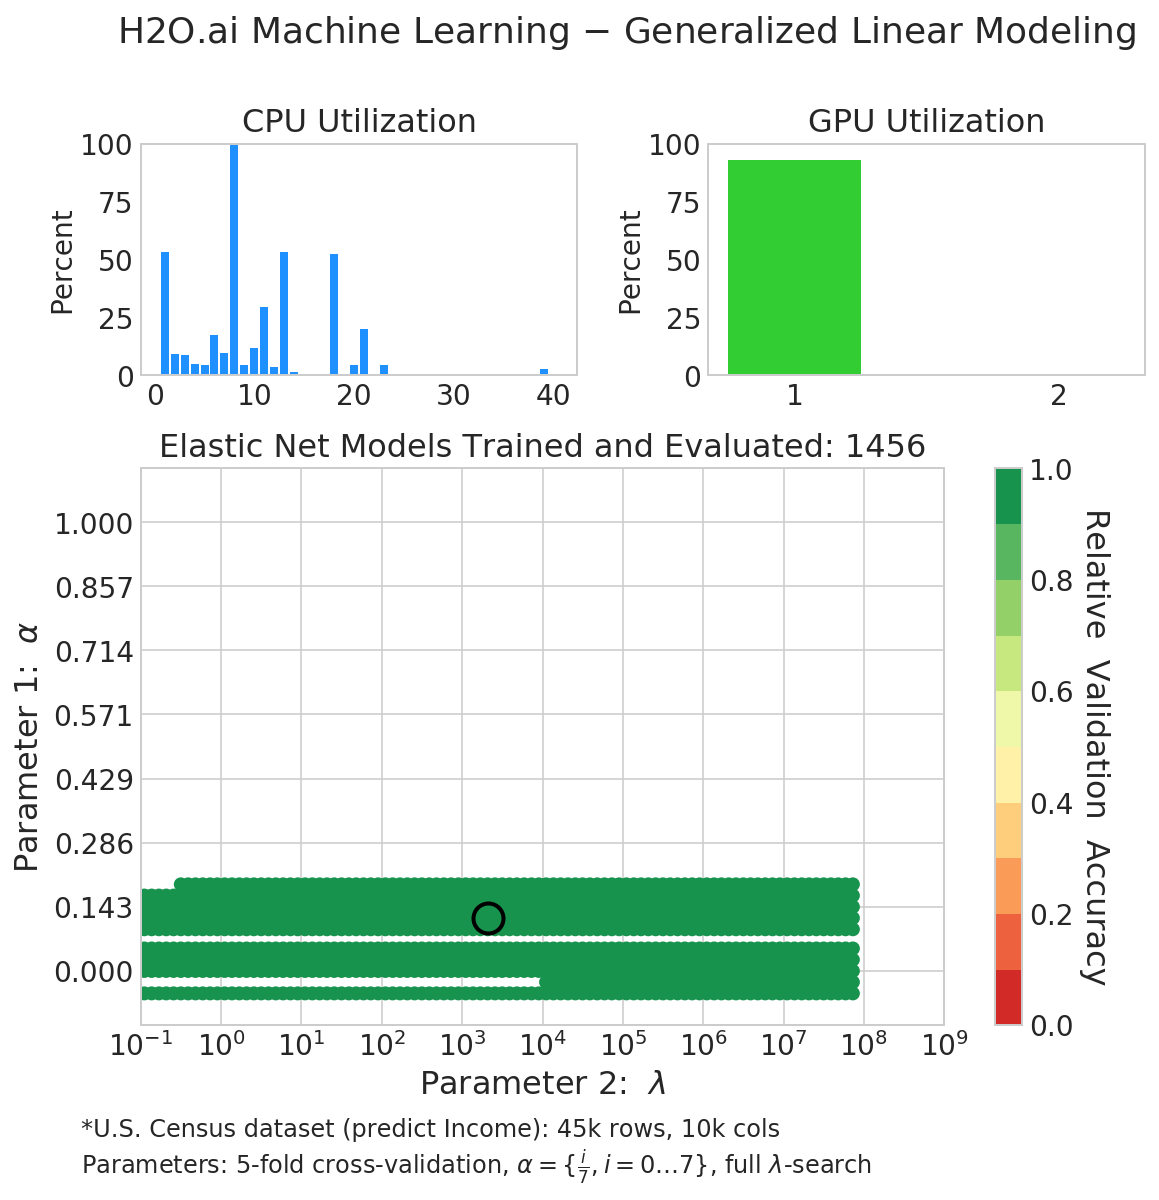

In [ ]:
from threading import Thread
pool_type = 1
if True or doanim:
    # Show Animation
    arg = deviceCount
    if pool_type == 0:
        background_thread = Thread(target=RunAnimation, args=(arg,))
        background_thread.start()
    else:
        RunAnimation(arg)